## Célula inicial – Importação de bibliotecas e carregamento da base
Execute esta célula antes das demais.

In [10]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Carregando o dataset de pinguins
penguins = sns.load_dataset('penguins')
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


## Questão 1 – Análise de valores ausentes e tipos de variáveis
**Enunciado (resumido):**

- Verifique se o dataset possui **valores ausentes**.
- Identifique quais colunas são **categóricas** e não serão usadas diretamente no K-Means.
- Crie um subconjunto apenas com **variáveis numéricas** e trate valores ausentes.


In [11]:
# Estrutura geral do dataset
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [12]:
# Verificando valores ausentes em cada coluna
penguins.isnull().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [13]:
# Conferindo as colunas existentes
print("Colunas do DataFrame penguins:")
print(penguins.columns.tolist())

# Lista desejada de colunas numéricas
colunas_desejadas = [
    'bill_length_mm',
    'bill_depth_mm',
    'flipper_length_mm',
    'body_mass_g',
    'year'  # opcional
]

# Mantém só as que realmente existem no DataFrame
cols_numericas = [c for c in colunas_desejadas if c in penguins.columns]

print("\nColunas numéricas que serão usadas:")
print(cols_numericas)

# Selecionando apenas colunas numéricas para o K-Means
penguins_numerico = penguins[cols_numericas].copy()

# Removendo linhas com valores ausentes nas colunas numéricas
penguins_numerico = penguins_numerico.dropna()

penguins_numerico.head()


Colunas do DataFrame penguins:
['species', 'island', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']

Colunas numéricas que serão usadas:
['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0


**Resposta resumida:**

- O dataset apresenta **valores ausentes** em algumas colunas (incluindo medidas físicas e `sex`).
- As colunas **categóricas principais** são: `species`, `island` e `sex`, que não serão usadas diretamente no K-Means.
- Para o K-Means, vamos seguir com as colunas numéricas selecionadas em `cols_numericas` e removemos linhas com `NaN`.

## Questão 2 – Análise descritiva e identificação inicial de agrupamentos
**Enunciado (resumido):**

- Use `.describe()` para visualizar estatísticas descritivas das variáveis numéricas.
- Gere alguns gráficos (opcional) e comente se já é possível suspeitar de quantos grupos existam nos dados.


In [14]:
# Estatísticas descritivas das variáveis numéricas
penguins_numerico.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


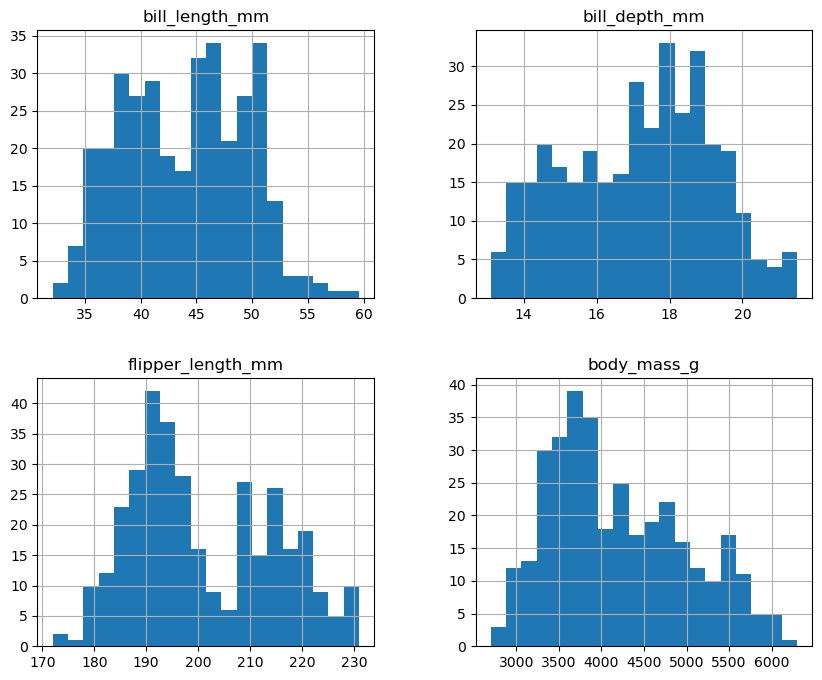

In [15]:
# Histogramas das variáveis numéricas (opcional, mas útil para visualização)
penguins_numerico.hist(bins=20, figsize=(10, 8));

In [16]:
# Matriz de correlação entre as variáveis numéricas
penguins_numerico.corr()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
bill_length_mm,1.000000,-0.235053,0.656181,0.595110
bill_depth_mm,-0.235053,1.000000,-0.583851,-0.471916
flipper_length_mm,0.656181,-0.583851,1.000000,0.871202
body_mass_g,0.595110,-0.471916,0.871202,1.000000


In [17]:
# Gráfico de dispersão entre comprimento e profundidade do bico,
# colorido pela espécie (apenas para visualização, não entra no K-Means)
penguins_dropna = penguins.dropna(subset=['bill_length_mm', 'bill_depth_mm', 'species'])
fig = px.scatter(
    penguins_dropna,
    x='bill_length_mm',
    y='bill_depth_mm',
    color='species',
    title='Relação entre bill_length_mm e bill_depth_mm por espécie'
)
fig.show()

**Resposta resumida:**

- A análise descritiva mostra diferenças claras de médias e dispersão entre as espécies.
- O gráfico de dispersão `bill_length_mm` vs `bill_depth_mm` sugere a existência de cerca de **3 grupos principais**.
- Isso é consistente com o fato de a base conter **3 espécies** (`Adelie`, `Chinstrap`, `Gentoo`).

## Questão 3 – Padronização das variáveis numéricas
**Enunciado (resumido):**

- Padronize as variáveis numéricas usando `StandardScaler`.
- Analise rapidamente o resultado dos dados padronizados.


In [18]:
from sklearn.preprocessing import StandardScaler

# Instanciando o scaler
scaler = StandardScaler()

# Ajustando e transformando os dados numéricos
penguins_scaled = scaler.fit_transform(penguins_numerico)

# Transformando em DataFrame para facilitar a análise
penguins_scaled_df = pd.DataFrame(
    penguins_scaled,
    columns=penguins_numerico.columns
)

penguins_scaled_df.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,-0.884499,0.785449,-1.418347,-0.564142
1,-0.811126,0.126188,-1.062250,-0.501703
2,-0.664380,0.430462,-0.421277,-1.188532
3,-1.324737,1.089724,-0.563715,-0.938776
4,-0.847812,1.748985,-0.777373,-0.689020


In [19]:
# Estatísticas dos dados padronizados
penguins_scaled_df.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,3.420000e+02,3.420000e+02,3.420000e+02,3.420000e+02
mean,1.662088e-16,-1.412775e-15,-8.310441e-16,4.155221e-17
std,1.001465e+00,1.001465e+00,1.001465e+00,1.001465e+00
min,-2.168526e+00,-2.054446e+00,-2.059320e+00,-1.875362e+00
25%,-8.615697e-01,-7.866355e-01,-7.773731e-01,-8.138982e-01
50%,9.686524e-02,7.547549e-02,-2.788381e-01,-1.895079e-01
75%,8.397670e-01,7.854492e-01,8.606705e-01,6.846384e-01
max,2.875868e+00,2.205397e+00,2.142618e+00,2.620248e+00


**Resposta resumida:**

- Após a padronização, cada variável passa a ter **média aproximadamente 0** e **desvio padrão aproximadamente 1**.
- Isso é importante porque o K-Means é sensível à escala: variáveis com valores maiores poderiam dominar a distância.

## Questão 4 – Aplicação do K-Means
**Enunciado (resumido):**

- Aplique o algoritmo K-Means aos dados padronizados.
- Use como sugestão **k = 3** (quantidade de espécies na base).
- Armazene o rótulo de cluster de cada observação.


In [20]:
from sklearn.cluster import KMeans

# Definindo o número de clusters
k = 3

kmeans = KMeans(
    n_clusters=k,
    random_state=42,
    n_init=10
)

# Ajustando o modelo aos dados padronizados
kmeans.fit(penguins_scaled_df)

# Rótulos (cluster) de cada pinguim
labels = kmeans.labels_

# Criando uma cópia do dataset (somente linhas sem NaN nas colunas numéricas)
penguins_cluster = penguins.loc[penguins_numerico.index].copy()
penguins_cluster['cluster'] = labels
penguins_cluster.head()

c:\Users\trend\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,cluster
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male,2
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female,2
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female,2
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female,2
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male,2


In [ ]:
# Inércia do modelo (soma das distâncias internas aos clusters)
kmeans.inertia_

379.3925027555175

**Resposta resumida:**

- Foi aplicado o **K-Means com k = 3** clusters sobre os dados padronizados.
- Cada linha recebeu um rótulo de cluster (`0`, `1` ou `2`), armazenado na coluna `cluster`.
- Em geral, esses clusters se aproximam bastante das três espécies da base.

## Questão 5 – Visualização dos clusters e centróides
**Enunciado (resumido):**

- Construa ao menos **dois gráficos de dispersão** mostrando os pontos e os **centróides** dos clusters.
- Sugestão:
  - Gráfico 1: `bill_length_mm` (eixo x) vs `bill_depth_mm` (eixo y)
  - Gráfico 2: escolha outra combinação, por exemplo `flipper_length_mm` vs `body_mass_g`.


In [ ]:
# Coordenadas dos centróides em escala padronizada
centroids_scaled = kmeans.cluster_centers_

# Convertendo os centróides de volta para a escala original
centroids_original = scaler.inverse_transform(centroids_scaled)
centroids_df = pd.DataFrame(
    centroids_original,
    columns=penguins_numerico.columns
)
centroids_df

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,47.525287,18.762069,196.896552,3902.011494
1,47.504878,14.982114,217.186992,5076.016260
2,38.208333,18.110606,188.401515,3584.659091


In [ ]:
# Gráfico 1 – bill_length_mm x bill_depth_mm com clusters e centróides
fig1 = px.scatter(
    penguins_cluster,
    x='bill_length_mm',
    y='bill_depth_mm',
    color='cluster',
    title='Clusters em bill_length_mm x bill_depth_mm',
    opacity=0.7
)

fig1.add_trace(
    go.Scatter(
        x=centroids_df['bill_length_mm'],
        y=centroids_df['bill_depth_mm'],
        mode='markers+text',
        marker=dict(size=15, symbol='x'),
        text=[f'C{i}' for i in range(len(centroids_df))],
        textposition='top center',
        name='Centróides'
    )
)

fig1.show()

In [ ]:
# Gráfico 2 – flipper_length_mm x body_mass_g com clusters e centróides
fig2 = px.scatter(
    penguins_cluster,
    x='flipper_length_mm',
    y='body_mass_g',
    color='cluster',
    title='Clusters em flipper_length_mm x body_mass_g',
    opacity=0.7
)

fig2.add_trace(
    go.Scatter(
        x=centroids_df['flipper_length_mm'],
        y=centroids_df['body_mass_g'],
        mode='markers+text',
        marker=dict(size=15, symbol='x'),
        text=[f'C{i}' for i in range(len(centroids_df))],
        textposition='top center',
        name='Centróides'
    )
)

fig2.show()

**Resposta resumida:**

- Os gráficos mostram como os dados se distribuem em relação aos clusters encontrados.
- Os centróides (`C0`, `C1`, `C2`) indicam o "centro" de cada grupo em termos das variáveis analisadas.
- Em geral, é possível observar boa separação dos grupos nas combinações escolhidas.

## Questão 6 – Aplicações práticas de algoritmos de clusterização
**Enunciado (resumido):**

Cite ao menos **3 utilidades/aplicações** de algoritmos de clusterização no mundo real.


### Resposta – Exemplos de aplicações de clusterização

1. **Segmentação de clientes em marketing**  
   - Agrupar clientes com comportamentos de compra semelhantes (ticket médio, frequência, tipos de produtos).
   - Permite campanhas mais direcionadas, programas de fidelidade específicos e aumento de conversão.

2. **Detecção de anomalias e fraudes**  
   - Transações bancárias ou acessos a sistemas que não se encaixam em nenhum cluster típico podem indicar fraude,
     invasão ou uso indevido.

3. **Agrupamento de textos/documentos (text mining)**  
   - Organização automática de notícias, artigos científicos ou tickets de suporte por tema, sem necessidade de rótulos prévios.

Outros exemplos possíveis (não obrigatórios, mas úteis para discussão):

- Agrupamento de regiões com perfis socioeconômicos parecidos para **planejamento público**.
- Agrupamento de pacientes com características clínicas semelhantes para **estudos médicos**.
- Agrupamento de imagens semelhantes em grandes bases de dados (por exemplo, fotos de produtos).